# Strain Mapping 

This notebook goes through the steps to calculate the strain using pyxem.  This data was taken from the paper:

```
Microstructure and microchemistry study of irradiation-induced precipitates in proton irradiated ZrNb alloys
Yu, Zefeng; Zhang, Chenyu; Voyles, Paul M.; He, Lingfeng; Liu, Xiang; Nygren, Kelly; Couet, Adrien
10.18126/2nj3-gyd8 
```

It shows a percipitate which arises from irradiation in the ZrNb sample.  The dataset shows the strain for one of these precipitates.  The results in this notebook are slightly different than those published as the paper only uses two diffraction spots to calculate strain.  Here we define a `basis` set of diffraction spots from an unstrained region of the sample and then use that basis set of spots to refine the diffraction spots found in the rest of the dataset.

Then a gradient tensor which maps each set of found points at (x,y) is calculated such that the tensor maps the points onto the basis.

Transforming that gradient tensor we can plot the percent strain in the E11 E22 and E33 directions as well as a Theta displacement. 

In this sample you can see that there is mostly compressive stress on the percipite as well as shear stress. Hot spots on the edge of the theta map suggest the presence of dislocations as well. 
<center><img src="Images/Strain Mapping.png" alt="StrainMapping" height="1000" width="1000"></center>

This functionaility has been checked to run in pyxem-0.19.0 (May 2024). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

# Contents

1. <a href='#gen'> Visualizing and Loading Data</a>
2. <a href='#avg'> Pattern Averaging the Data</a>
3. <a href='#temp'> Filtering with a Disk Template Matching</a>
4. <a href='#pks'> Peak Finding</a>
5. <a href='#strain'> Determining Strain</a>
6. <a href='#vis'> Visualizing Strain</a>

# <a id='gen'></a> 1. Visualizing, Loading and Centering Data

Import pyxem and other required libraries

In [1]:
import pyxem as pxm
import hyperspy.api as hs
print(pxm.__version__)

0.19.dev0


In [2]:
# Load the data. This is an example dataset downloaded from a Zenodo Repository and cached on your computer.
s = pxm.data.zrnb_precipitate(allow_download=True, lazy=True)

In [3]:
s.axes_manager

Navigation axis name,size,index,offset,scale,units
,60,0,0.5,0.9,nm
,40,0,0.5,0.9,nm
Signal axis name,size,,offset,scale,units
,256,,-6.564102564102564,0.05128205128205128,nm^-1
,256,,-6.564102564102564,0.05128205128205128,nm^-1


In [4]:
# Set the scale 
s.calibration.scale= 0.051

In [5]:
# set axis labels
s.axes_manager.signal_axes[0].name="kx"
s.axes_manager.signal_axes[1].name="ky"

In [6]:
# Set the figure dpi so that things show up nicely side by side (This is different for every monitor. 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 60

### Plot the dataset

We can use the `%matplotlib ipympl` jupyter magic comand to make it interactive

In [7]:
%matplotlib ipympl
s.plot()

# <a id='avg'></a> 2. Pattern Averaging the Data


Sometimes we see some varible intensity in the disks.  We can actually correct some of this by just gaussian filtering the data in real space.  
For strain mapping we can make this very local (sigma = 0.5,0.5,0.0,0.0) and we don't lose much spatial resolution (its equivlent to having a slightly larger probe size in real-space).  Of course this also greatly increses your Signal to noise ratio which is more of what we are interested in :). 


In [8]:
from dask_image.ndfilters import gaussian_filter # For lazy signals
#from scipy.ndimage import gaussian_filter

In [9]:
s = pxm.data.zrnb_precipitate(allow_download=True, lazy=True)

In [10]:
# filter the dataset
filtered = s.filter(gaussian_filter, sigma=(1,1,0,0)) # in pixels 

In [11]:
filtered

<LazyElectronDiffraction2D, title: , dimensions: (60, 40|256, 256)>

In [12]:
# plot the filtered dataset (Lets compare the two!)
%matplotlib ipympl

filtered.plot(vmax="99th")
s.plot(axes_manager=filtered.axes_manager, vmax="99th")


[########################################] | 100% Completed | 2.42 sms


# <a id='temp'></a> 3. Filtering with a Disk Template Matching


Then we can use template matching before finding the diffraction vectors in the dataset.  I like to do this lazily and then adjust the parameters.  The disk_r can be read from the size of the direct beam but it is also good to view the template result to make sure that things worked correctly.  If your disk_r is too small you might end up with a valley at the center of the disk and if your radius is too large you end up with a platau at the center.

This is shown below where the ideal radius is around ~11 pixels

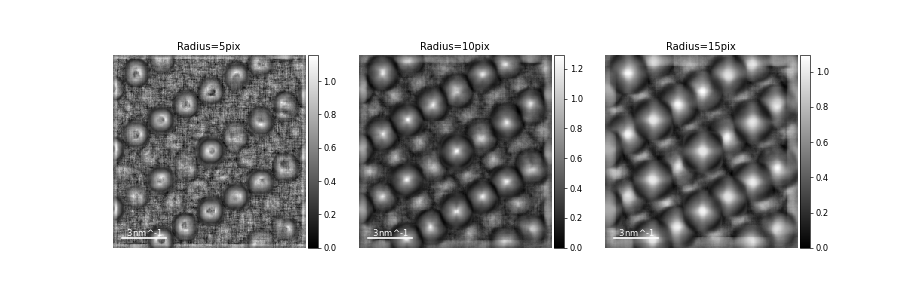

In [13]:
# lets just try to see what the effect of different disk radii is:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
one_pattern=filtered.inav[5,5]
hs.plot.plot_images([one_pattern.template_match_disk(r) for r in [5,10,15]], 
                    axes_decor="off",
                    scalebar="all",
                    label=["Radius=5pix","Radius=10pix","Radius=15pix"], fig=fig)
plt.show()

In [14]:
# template matching using a disk.  
temp = filtered.template_match_disk(disk_r=11, subtract_min=False)

In [15]:
temp.plot()

[########################################] | 100% Completed | 6.14 sms


# <a id='pks'></a> 4. Peak Finding

Now we can see what a good value for peak finding is.  We can either use the interactive peak finding in hyperspy but I tend to just play with the vmin value with plotting until I get a reasonable min value.

WARNING | Hyperspy | Estimated number of bins using `bins='fd'` is too large (366). Capping the number of bins at `max_num_bins=250`. Consider using an alternative method for calculating the bins such as `bins='scott'`, or increasing the value of the `max_num_bins` keyword argument. (hyperspy.misc.hist_tools:178)


[########################################] | 100% Completed | 103.08 ms


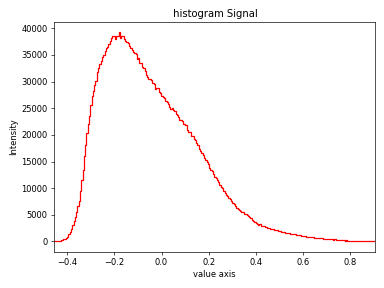

In [16]:
# lets look at the histgram for just a couple of points
temp.inav[3:10, 3:10].get_histogram().plot()

In [17]:
# Lets plot the data with an adjusted vmin 
temp.plot(vmin=.4)

In [18]:
# get the diffraction vectors
vect = temp.get_diffraction_vectors(threshold_abs=0.4,
                        distance=10, get_intensity=False)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


In [19]:
#display the diffraction vectors
vect

<LazyDiffractionVectors, title: , dimensions: (60, 40|ragged)>

In [20]:
vect.inav[0,0]

<LazyDiffractionVectors, title: , dimensions: (|ragged)>

In [21]:
#plot the diffraction vectors
vect.plot_diffraction_vectors_on_signal(s, vmax="95th")

/Users/carterfrancis/PycharmProjects/pyxem/pyxem/signals/diffraction_vectors.py:915: VisibleDeprecationWarning: Function `plot_diffraction_vectors_on_signal()` is deprecated and will be removed in version 1.0.0. Use `pyxem.signals.DiffractionVectors.to_markers()` instead.
  since="0.17.0",


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


# <a id='strain'></a> 5. Determining Strain

First we filter the vactors based on their magnitude. This gets rid of the zero beam and weaker peaks farther out!

In [22]:
# filter the magnitude of the vectors
vect_filtered = vect.filter_magnitude(min_magnitude=3.5, max_magnitude=4.5)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


In [23]:
# display the vectors
lazy_vect = vect_filtered.as_lazy()

Defining the basis vector far from the region of interest

In [24]:
# get a basis from the unstrained region
basis = vect_filtered.inav[4,4]

In [25]:
basis.compute()

[########################################] | 100% Completed | 524.17 ms


In [26]:
# white for current data, red for basis.
m = vect_filtered.to_markers(edgecolor="w",facecolor="none", sizes=(40), lw=4)
basis_markers = hs.plot.markers.Points(basis.data[0][:,::-1], edgecolor="r",facecolor="none", sizes=(40), lw=3 )

filtered.plot(vmax="99th")
filtered.add_marker((m, basis_markers))



WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


In [27]:
from pyxem.generators.displacement_gradient_tensor_generator import get_DisplacementGradientMap

## 5.1 Fitting an Ellipse for the Strain

Let's get a tensor strain map.  Basically we can determine the best elliptical transfromation to map from the basis set of vectors to the strained vectors.  We can also determine the residual and use that to improve the fits or indentify area where we are less confident about the fit.


In [28]:
filtered_data = vect_filtered.filter_basis(basis.data[0])

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


In [29]:
filtered_data.compute()

[########################################] | 100% Completed | 9.59 sms


In [30]:
# Lets get a tensor strain map.
strain_map, residual = get_DisplacementGradientMap(filtered_data, basis.data[0], return_residuals=True)

[########################################] | 100% Completed | 105.86 ms
[########################################] | 100% Completed | 105.46 ms


In [31]:
# get the magnitude of the residual
std_err = (residual**2).sum(axis=-1)**0.5
std_err.set_signal_type()

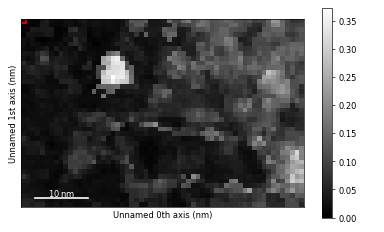

In [32]:
#plot the error.
std_err.plot()

In [33]:
# visualize the error and determine how to better fit the data.
m = filtered_data.to_markers(edgecolor="w",facecolor="none", sizes=(40))
basis_markers = hs.plot.markers.Points(basis.data[0][:,::-1], edgecolor="r",facecolor="none", sizes=(40) )

filtered.plot(navigator=std_err, vmax="99th")
filtered.add_marker((m, basis_markers))

[########################################] | 100% Completed | 105.76 ms


In [34]:
# get the strain maps.
maps = strain_map.get_strain_maps()

[########################################] | 100% Completed | 105.59 ms
[########################################] | 100% Completed | 105.60 ms
[########################################] | 100% Completed | 105.60 ms


# <a id='vis'></a> 6. Visualizing the Strain

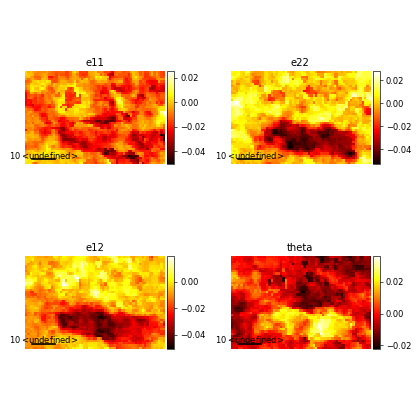

In [35]:
# use plot images to show the images.
import matplotlib.pyplot as plt
f= plt.figure(figsize=(7,7))
hs.plot.plot_images(maps,per_row=2,fig=f,
                    label=["e11","e22", "e12", "theta"],
                    tight_layout=True, cmap="hot", axes_decor="off", scalebar="all", scalebar_color="black")
plt.show()
# save the figure
fig.savefig("strainmaps.png", dpi=300)

### 6.1 Visualizing the Error

It's a good idea to look at the STD ERROR and Identify regions where the strain mapping didn't work very well.  It's pretty easy (as it is in this case) to determine __why__ the fit for the strain didn't work very well.  Usually you can remove the problematic vector from the basis set and reduce the error to get a better fit. 

In [36]:
m = filtered_data.to_markers(edgecolor="w",facecolor="none", sizes=(45), linewidth=4)
basis_markers = hs.plot.markers.Points(basis.data[0][:,::-1], edgecolor="r",facecolor="none", sizes=(45), linewidth=4 )

filtered.plot(navigator=std_err,vmax="99th", navigator_kwds =dict(cmap="hot"))
filtered.add_marker((m, basis_markers))

[########################################] | 100% Completed | 103.48 ms
